In [5]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.dummy import DummyClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [6]:
!wget https://tickettagger.blob.core.windows.net/datasets/dataset-labels-top3-30k-real.txt

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [7]:
!pip install requests


In [10]:
#download the dataset from ticket tagger
import requests

url = "https://tickettagger.blob.core.windows.net/datasets/dataset-labels-top3-30k-real.txt"
response = requests.get(url)

with open("git_issue.csv", "wb") as file:
    file.write(response.content)


In [13]:
#import dataset
df = pd.read_csv("git_issue.csv", header = None)

In [14]:
df.head()

,0
0,__label__enhancement Exception handling # Desc...
1,__label__enhancement Subpasses in MSL and HLSL...
2,__label__enhancement Collect new discovered no...
3,__label__enhancement Lock property : several p...
4,__label__bug Return default location type labe...


In [17]:
#Text cleaning and extractrion
#extraxt and split the labels using regular expression
#split into enhancement,bug and question
df[0].str.split(r'(__label__enhancement)|(__label__bug)|(__label__question)', expand = True)

,0,1,2,3,4
0,,__label__enhancement,None,None,Exception handling # Description The methods...
1,,__label__enhancement,None,None,Subpasses in MSL and HLSL Sorry for all the i...
2,,__label__enhancement,None,None,Collect new discovered nodes Collect new adde...
3,,__label__enhancement,None,None,Lock property : several properties at once
4,,None,__label__bug,None,Return default location type label if custom ...
...,...,...,...,...,...
29995,,__label__enhancement,None,None,[TW-241] new column format; recur.short _Davi...
29996,,None,__label__bug,None,Error When using the example. [HTML] Uncau...
29997,,None,__label__bug,None,CorrelationId should be generated every request
29998,,__label__enhancement,None,None,screenshot sidecar should size the sidecar to...


In [18]:
df_new = df[0].str.split(r'(__label__enhancement)|(__label__bug)|(__label__question)', expand = True)

## Feature Engineering|extraction


In [20]:
#Extract only rows with enhancement
df_new[df_new[1] == '__label__enhancement'][[1,4]]

,1,4
0,__label__enhancement,Exception handling # Description The methods...
1,__label__enhancement,Subpasses in MSL and HLSL Sorry for all the i...
2,__label__enhancement,Collect new discovered nodes Collect new adde...
3,__label__enhancement,Lock property : several properties at once
5,__label__enhancement,Randomize: remove sliders
...,...,...
29992,__label__enhancement,Level design Create level 0 (tutorial) and le...
29994,__label__enhancement,"[TW-85] task ""properties"" or ""casual attribut..."
29995,__label__enhancement,[TW-241] new column format; recur.short _Davi...
29998,__label__enhancement,screenshot sidecar should size the sidecar to...


In [30]:
enh_df = df_new[df_new[1] == '__label__enhancement'][[1,4]]

In [31]:
#Extract only rows with bug
df_new[df_new[2] == '__label__bug'][[2,4]]

,2,4
4,__label__bug,Return default location type label if custom ...
6,__label__bug,[TW-417] JSON export has extra commas (on 2.1...
7,__label__bug,System.AccessViolationException: my program t...
8,__label__bug,Topic mining fails with UnicodeEncodeError ``...
10,__label__bug,Preflight and non-batching requests throw an ...
...,...,...
29987,__label__bug,Page scolls when (de-)zooming on a document
29991,__label__bug,1.6.1 Twitter No Response There is a same pro...
29993,__label__bug,BUG: type-material.less breaks linting ### Bu...
29996,__label__bug,Error When using the example. [HTML] Uncau...


In [32]:
bug_df = df_new[df_new[2] == '__label__bug'][[2,4]]

In [33]:
#Extract only rows with question
df_new[df_new[3] == '__label__question'][[3,4]]

,3,4
12,__label__question,Avoiding the default NotEmpty::IS_EMPTY valid...
30,__label__question,Is there a way to authenticate the video stre...
68,__label__question,"Disable rotation of the plugin Hi, I disable..."
112,__label__question,Question: Rule and Strategy over certain time...
124,__label__question,Is the .postcssrc file still necessary?
...,...,...
29940,__label__question,小白问题：监控页面配置了密码访问，如何通过http获取View JSON。 如题
29942,__label__question,Possible to support 1.0.0-* and 2.0.0-rc2-079...
29950,__label__question,Input/output error when getattr() called when...
29983,__label__question,No example ? I don't see any application of ...


In [36]:
question_df = df_new[df_new[3] == '__label__question'][[3,4]]

### Assign names to each of the columns and merge them together 

In [37]:
#Assign names to each columns
enh_df.columns = ['label', 'description']
bug_df.columns = ['label', 'description']
question_df.columns = ['label', 'description']

In [42]:
#concatinate the columns
df = pd.concat([enh_df, bug_df, question_df])

In [43]:
df.head()

,label,description
0,__label__enhancement,Exception handling # Description The methods...
1,__label__enhancement,Subpasses in MSL and HLSL Sorry for all the i...
2,__label__enhancement,Collect new discovered nodes Collect new adde...
3,__label__enhancement,Lock property : several properties at once
5,__label__enhancement,Randomize: remove sliders


In [44]:
df.shape

(30000, 2)

In [45]:
#save the dataset 
df.to_csv('github-issue.csv')

### Clean the data

In [47]:
#remove the __label__ 
df['label'].str.replace('__label__','')

0        enhancement
1        enhancement
2        enhancement
3        enhancement
5        enhancement
            ...     
29940       question
29942       question
29950       question
29983       question
29990       question
Name: label, Length: 30000, dtype: object

In [48]:
df['label'] = df['label'].str.replace('__label__','')

In [49]:
#save the dataset 
df.to_csv('github-issue-label.csv')

### Class Distribution Analysis

In [52]:
df['label'].value_counts()

bug            15286
enhancement    12193
question        2521
Name: label, dtype: int64

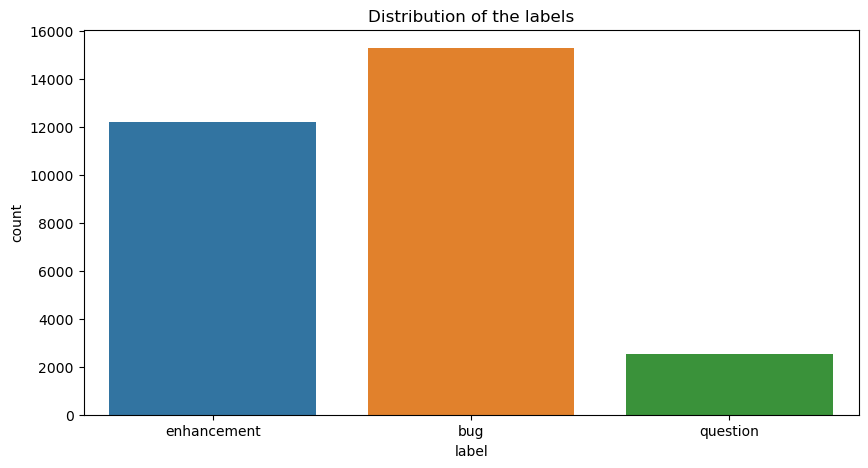

In [56]:
fig = plt.figure(figsize = (10,5))
sns.countplot(data = df, x = 'label')
plt.title('Distribution of the labels')
plt.show()

### Text cleaning 

In [62]:
df.iloc[0].description

' Exception handling # Description  The methods that use try/catch blocks are quite limiting. Simply throw the exceptions and let users handle them. New idea: an exception handler wrapper class?    # Technical Information  | Information | Value |  |--|--|  | Operating System | Irrelevant |  |Architecture | Irrelevant |  | JavaEssentials Version| 1.2.2 Beta 1 |  '

In [63]:
!pip install neattext

     ---------------------------------------- 0.0/114.7 kB ? eta -:--:--
     ---------------------------------------  112.6/114.7 kB ? eta -:--:--
     ------------------------------------ 114.7/114.7 kB 607.5 kB/s eta 0:00:00


In [65]:
#remove stop words and covert everything to lower case
import neattext.functions as nfx
df['description'] = df['description'].apply(lambda x: nfx.remove_stopwords(str(x).lower()))


Because, some of the special characters are vital informations we may not consider removing it

### Build model using pipline

In [100]:
#split the dataset
X = df['description']
y = df['label']

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 42)

In [102]:
#create pipeline models
pipe_base = Pipeline(steps = [('cv',CountVectorizer()), ('dummy', DummyClassifier())])
pipe_nb = Pipeline(steps = [('cv',CountVectorizer()), ('nb', MultinomialNB())])
pipe_dt = Pipeline(steps = [('cv',CountVectorizer()), ('dummy', DecisionTreeClassifier())])
pipe_lr = Pipeline(steps = [('cv',CountVectorizer()), ('dummy', LogisticRegression())])
pipe_rf = Pipeline(steps = [('cv',CountVectorizer()), ('dummy', RandomForestClassifier())])

In [103]:
#build base model
pipe_base.fit(X_train, y_train)

Pipeline(steps=[('cv', CountVectorizer()), ('dummy', DummyClassifier())])

In [104]:
#accuracy
pipe_base.score(X_test,y_test)

0.5091111111111111

In [105]:
#build naive bayes model
pipe_nb.fit(X_train, y_train)

Pipeline(steps=[('cv', CountVectorizer()), ('nb', MultinomialNB())])

In [106]:
#accuracy
pipe_nb.score(X_test,y_test)

0.6584444444444445

In [107]:
#build decision tree model
pipe_dt.fit(X_train, y_train)

Pipeline(steps=[('cv', CountVectorizer()), ('dummy', DecisionTreeClassifier())])

In [108]:
#accuracy
pipe_dt.score(X_test,y_test)

0.6695555555555556

In [109]:
#build logistic regression model
pipe_lr.fit(X_train, y_train)

C:\Users\USER\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('cv', CountVectorizer()), ('dummy', LogisticRegression())])

In [110]:
#accuracy
pipe_lr.score(X_test,y_test)

0.7303333333333333

In [84]:
#build random forest model
pipe_rf.fit(X_train, y_train)

Pipeline(steps=[('cv', CountVectorizer()), ('dummy', RandomForestClassifier())])

In [85]:
#accuracy
pipe_rf.score(X_test,y_test)
#because of excecution time, I will not use random forest

0.742

In [111]:
y_pred = pipe_lr.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         bug       0.77      0.79      0.78      4582
 enhancement       0.72      0.75      0.74      3679
    question       0.38      0.25      0.30       739

    accuracy                           0.73      9000
   macro avg       0.63      0.60      0.61      9000
weighted avg       0.72      0.73      0.72      9000



In [112]:
#accuracy
pipe_lr.score(y_test,y_pred)

0.7395555555555555

<Figure size 500x500 with 0 Axes>

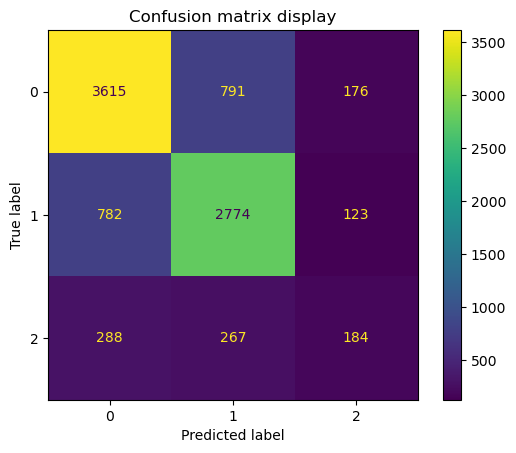

In [118]:
fig = plt.figure(figsize = (5,5))
cm = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()
plt.title('Confusion matrix display')
plt.show()

In [119]:
#save the model
import joblib

In [120]:
#save the model
model_file = open("pipe_lr_gh_issue_classifier.pkl","wb")
joblib.dump(pipe_lr,model_file)
model_file.close()

In [121]:
#predict unseen data
#this example is actually a bug in the issue label
ex1 = "Input Widgets re-run the entire app every time"
pipe_lr.predict([ex1])

array(['bug'], dtype=object)

In [123]:
#example 2 is enhancement
exp2 = "Request: on session start/shutdown hooks"
pipe_lr.predict([exp2])

array(['enhancement'], dtype=object)